# Configuring preacuired dataset for the DT AFM Microscope

This notebook provides a fundamental example of creating and saving a basic pre-acquired SPM dataset for subsequent use with the DTMicroscope.

The SPM results are saved in the NSID format (see [NSID documentation](https://pycroscopy.github.io/pyNSID/nsid.html)).

* To save in the NSID format, your data should be organized as a dictionary containing only `sidpy.Dataset` objects.
* The dataset containing scans should be saved as a `sidpy.Dataset` with the `IMAGE` data type. Spectroscopic data should be saved as a `sidpy.Dataset` with either the `SPECTRAL_IMAGE` or `POINT_CLOUD` data type.


In [1]:
import numpy as np

import SciFiReaders
import sidpy
import pyNSID

import h5py
import os

import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='pyNSID')

%matplotlib widget

You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.


In [2]:
# functions for saving dictionary in the h5 file

def save_dataset(dataset, filename=None):
    """ Saves a dataset to a file in pyNSID format
    
    Parameters
    ----------
    dataset: sidpy.Dataset
        the data
    filename: str
        name of file to be opened, if filename is None, a QT file dialog will try to open
    """
    h5_file = h5py.File(filename, mode='w')
    path, file_name = os.path.split(filename)
    basename, _ = os.path.splitext(file_name)
    print(file_name, basename)
    if isinstance(dataset, dict):
        h5_group = save_dataset_dictionary(h5_file, dataset)
        h5_file.close()
    elif isinstance(dataset, sidpy.Dataset):
        h5_dataset = save_single_dataset(h5_file, dataset, h5_group=h5_group)
        h5_file.close()
    else:
        h5_file.close()
        raise TypeError('Only sidpy.datasets or dictionaries can be saved')
        
        
def save_dataset_dictionary(h5_file, datasets):
    h5_measurement_group = sidpy.hdf.prov_utils.create_indexed_group(h5_file, 'Measurement_')
    for key, dataset in datasets.items():
        print(key)
        if key[-1] == '/':
            key = key[:-1]
        if isinstance(dataset, sidpy.Dataset):
            h5_group = h5_measurement_group.create_group(key)
            h5_dataset = pyNSID.hdf_io.write_nsid_dataset(dataset, h5_group)
            dataset.h5_dataset = h5_dataset
            h5_dataset.file.flush()
        elif isinstance(dataset, dict):
            sidpy.hdf.hdf_utils.write_dict_to_h5_group(h5_measurement_group, dataset, key)
        else:
            print('could not save item ', key, 'of dataset dictionary')
    return h5_measurement_group

In [3]:
#path to the measurement file
file_path = "./temp/scan_0001.ibw"

#path to spectroscopical data
file_spectra = "./temp/spectra4.h5"

## 1) Import measurement file 

In [4]:
reader= SciFiReaders.IgorIBWReader(file_path)
datasets = reader.read()

#shift the (0,0) location to the center of scan
for i,key in enumerate(datasets):
    datasets[key].x = datasets[key].x -  np.mean(datasets[key].x.values)
    datasets[key].y = datasets[key].y -  np.mean(datasets[key].y.values)
    datasets[key].original_metadata['uuid'] = str(i)
    datasets[key].original_metadata['associated-spec'] = '6'

print(datasets)

{'Channel_000': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: HeightRetrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_001': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: Amplitude1Retrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_002': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: Amplitude2Retrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_003': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: Phase1Retrace (deg)
 and Dimensions: 
x:  x (deg) of size (256,)
y:  y (de

## 2) Importing Spectroscopic Data

You may need to create a custom function to transform your initial spectroscopic data into the `sidpy` format. If applicable, you can also utilize `SciFiReaders` to facilitate this process.

In [5]:
reader = SciFiReaders.NSIDReader(file_spectra)
spectral_data = reader.read()
reader.close()

print(spectral_data)
spectral_data['Channel_000'].original_metadata['uuid'] = '6'
spectral_data['Channel_000'].original_metadata['associated-image'] = ['0', '1', '2', '3', '4', '5']

{'Channel_000': sidpy.Dataset of type POINT_CLOUD with:
 dask.array<array, shape=(1600, 8, 198), dtype=float64, chunksize=(1600, 8, 198), chunktype=numpy.ndarray>
 data contains: Response (a.u.)
 and Dimensions: 
point number:  Point number (generic) of size (1600,)
channel:  Channel (generic) of size (8,)
Voltage:  V (V) of size (198,)}


## 3) Combine Spectroscopic and Image Data into a Single Dictionary

It is crucial to ensure that all spectroscopic and image data share the same spatial coordinate system. Failure to do so may result in incorrect positioning of spectra within the overview images, and misalignment between the overview images themselves.

In [6]:
datasets['Channel_006'] = spectral_data['Channel_000']
print(datasets)

{'Channel_000': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: HeightRetrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_001': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: Amplitude1Retrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_002': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: Amplitude2Retrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_003': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float32, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: Phase1Retrace (deg)
 and Dimensions: 
x:  x (deg) of size (256,)
y:  y (de

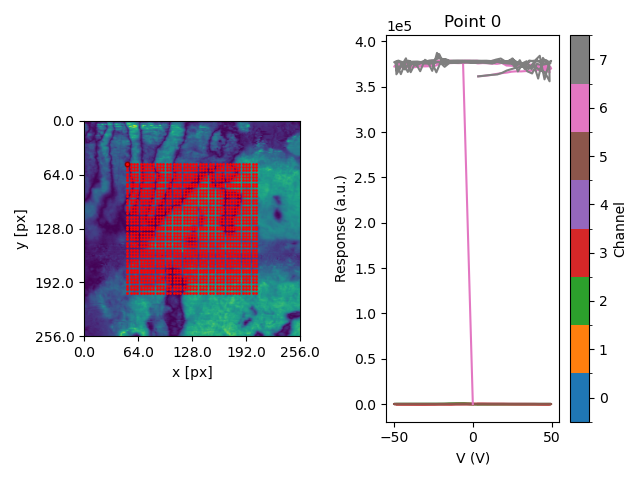

In [7]:
view = datasets['Channel_006'].plot(base_image=datasets['Channel_001'], origin='lower')

#we need to cope somehow with multichannel images when chanels have different dinatrions

## 4) Save data and import it to check

In [8]:
#save into NSID dataset
save_dataset(datasets, filename='/Users/borisslautin/Documents/GitHub/DTMicroscope/DTMicroscope/test/datasets/dset_spm1.h5')

dset_spm1.h5 dset_spm1
Channel_000
Channel_001
Channel_002
Channel_003
Channel_004
Channel_005
Channel_006


In [33]:
reader = SciFiReaders.NSIDReader('/Users/borisslautin/Documents/GitHub/DTMicroscope/DTMicroscope/test/datasets/dset_spm1.h5')
saved_data = reader.read()
reader.close()

print(saved_data)

{'Channel_000': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float64, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: HeightRetrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_001': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float64, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: Amplitude1Retrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_002': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float64, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: Amplitude2Retrace (m)
 and Dimensions: 
x:  x (m) of size (256,)
y:  y (m) of size (256,), 'Channel_003': sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(256, 256), dtype=float64, chunksize=(256, 256), chunktype=numpy.ndarray>
 data contains: Phase1Retrace (deg)
 and Dimensions: 
x:  x (deg) of size (256,)
y:  y (de

? Multichannel images
? Datasets for combinatorial libraries

In [36]:
saved_data['Channel_006'].original_metadata['associated-image']

array([b'0', b'1', b'2', b'3', b'4', b'5'], dtype='|S1')